<a href="https://colab.research.google.com/github/suyashss/nn_test/blob/master/BEE-GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import tensorflow.keras as keras

In [0]:
import matplotlib.pyplot as plt
def display_images(images,n):
  #print(images.shape)
  fig = plt.figure(figsize=(n*1.5,3))
  for i in range(n):
    img = images[i,:,:]
    plt.subplot(1,n,i+1)
    plt.imshow(img,cmap="binary")
    plt.axis("off")
  plt.show()    

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving honey-bee-annotated-images.zip to honey-bee-annotated-images.zip
User uploaded file "honey-bee-annotated-images.zip" with length 52950294 bytes


In [7]:
!unzip honey-bee-annotated-images.zip

Archive:  honey-bee-annotated-images.zip
  inflating: bee_data.csv            
  inflating: bee_imgs/bee_imgs/001_043.png  
  inflating: bee_imgs/bee_imgs/001_044.png  
  inflating: bee_imgs/bee_imgs/001_046.png  
  inflating: bee_imgs/bee_imgs/001_047.png  
  inflating: bee_imgs/bee_imgs/001_050.png  
  inflating: bee_imgs/bee_imgs/001_051.png  
  inflating: bee_imgs/bee_imgs/001_054.png  
  inflating: bee_imgs/bee_imgs/001_056.png  
  inflating: bee_imgs/bee_imgs/001_078.png  
  inflating: bee_imgs/bee_imgs/001_082.png  
  inflating: bee_imgs/bee_imgs/001_083.png  
  inflating: bee_imgs/bee_imgs/001_085.png  
  inflating: bee_imgs/bee_imgs/001_091.png  
  inflating: bee_imgs/bee_imgs/001_092.png  
  inflating: bee_imgs/bee_imgs/001_093.png  
  inflating: bee_imgs/bee_imgs/001_094.png  
  inflating: bee_imgs/bee_imgs/001_095.png  
  inflating: bee_imgs/bee_imgs/001_096.png  
  inflating: bee_imgs/bee_imgs/001_097.png  
  inflating: bee_imgs/bee_imgs/001_118.png  
  inflating: bee_imgs

In [0]:
img_test = keras.preprocessing.image.load_img('bee_imgs/bee_imgs/046_197.png')

In [19]:
#%matplotlib inline
img_test.size

(44, 53)

In [0]:
img_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,)

In [70]:
train_generator = img_gen.flow_from_directory(
          './bee_imgs/', target_size=(30, 30),
        batch_size=32,color_mode='grayscale',)

Found 5172 images belonging to 1 classes.


In [0]:
(x_train,y_train)= train_generator.next()

In [76]:
x_train.shape,y_train.shape

((32, 30, 30, 1), (32, 1))

In [37]:
x_train[1,2,3,:]

array([0.26666668], dtype=float32)

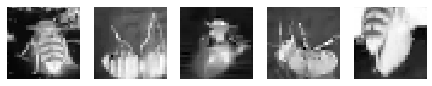

In [90]:
display_images(x_train.squeeze(),5)

In [0]:
type(x_train[0,0][0])

numpy.float32

In [91]:
x_train.shape

(32, 30, 30, 1)

In [0]:
import numpy as np

In [0]:
codings_size = 30

In [0]:
generator = keras.models.Sequential([
                                     keras.layers.Dense(100,activation="selu",input_shape=[codings_size]),
                                     keras.layers.Dense(150,activation="selu"),
                                     keras.layers.Dense(30*30,activation="sigmoid"),
                                     keras.layers.Reshape([30,30,1])
])

In [64]:
tgen = generator(tf.random.normal(shape=[batch_size,codings_size]))
print(tgen.shape)

(32, 30, 30, 1)


In [0]:
discriminator = keras.models.Sequential([
                                         keras.layers.Flatten(input_shape=[30,30,1]),
                                          keras.layers.Dense(150,activation="selu"),
                                      keras.layers.Dense(100,activation="selu"),
                                      keras.layers.Dense(1,activation="sigmoid"),
])

In [0]:
gan = keras.models.Sequential([generator,discriminator])

In [0]:
discriminator.compile(loss="binary_crossentropy",optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy",optimizer="rmsprop")

In [0]:
batch_size = 32

In [0]:
def train_gan(gan,dataset,batch_size,codings_size,n_epochs=50):
  generator,discriminator = gan.layers
  for epoch in range(n_epochs):
    (X_batch,y_batch) = train_generator.next()
    #print("Shape is",X_batch.shape)
    # Train discriminator
    noise = tf.random.normal(shape=[batch_size,codings_size])
    generated_images = generator(noise)
    if (epoch+1) % 10 == 0:
      display_images(tf.squeeze(generated_images),8)
    X_fake_and_real = tf.concat([generated_images,X_batch],axis=0)
    y1 = tf.constant([[0.]]*batch_size + [[1.]]*batch_size)
    discriminator.trainable = True
    discriminator.train_on_batch(X_fake_and_real,y1)
    # Train the generator
    noise = tf.random.normal(shape=[batch_size,codings_size])
    y2 = tf.constant([[1.]]*batch_size)
    discriminator.trainable = False
    gan.train_on_batch(noise,y2)

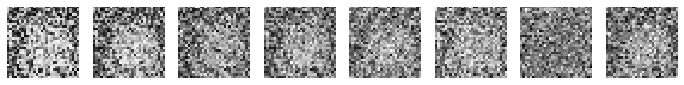

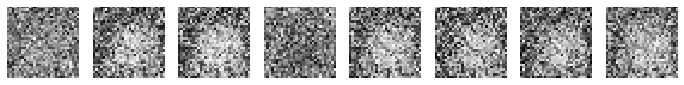

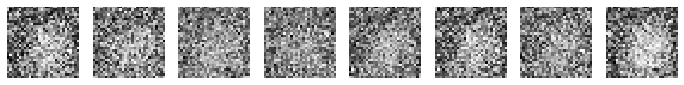

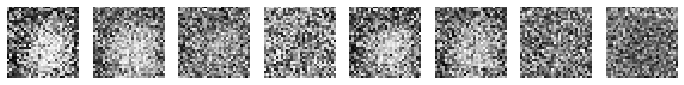

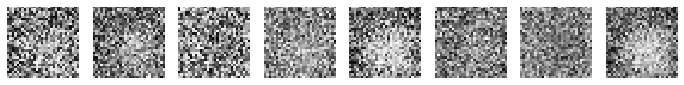

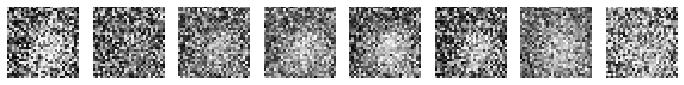

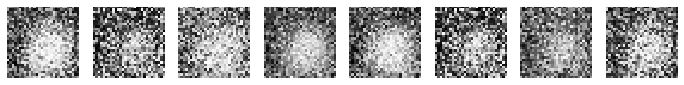

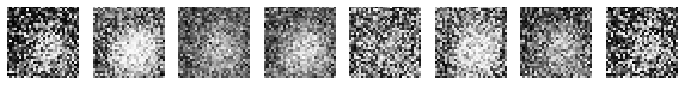

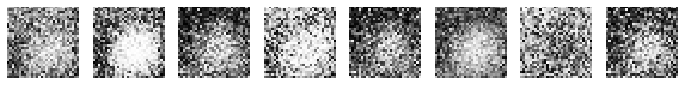

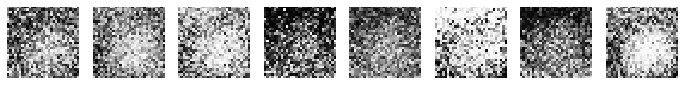

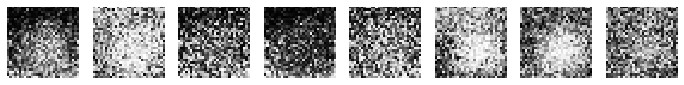

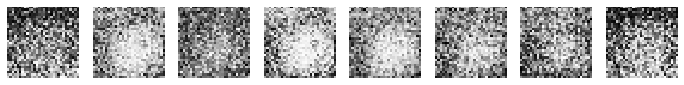

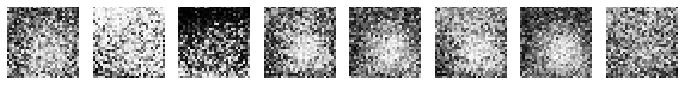

ValueError: ignored

In [89]:
train_gan(gan,dataset,batch_size,codings_size,200)